## Import Libraries

In [1]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Scikit-learn tools
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

# TensorFlow / Keras core
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    Dense,
    Dropout,
    LSTM,
    GRU,
    Bidirectional,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint,
)

# Keras Tuner
from keras_tuner.tuners import RandomSearch

## Data Preprocessing (General)

In [2]:
# Load data
df = pd.read_csv("../Movie reviews.csv")

# Display the data
df

,Review,Score,"Are there ways for you to generate more data? Spliting up sentences, would that help?",Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,NaN,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,NaN,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,NaN,Malay
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,NaN,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,NaN,Malay
...,...,...,...,...
522,Pening,0.7,NaN,Malay
523,Berkesan,0.2,NaN,Malay
524,Mengujakan,0.1,NaN,Malay
525,Sederhana and teruk,0.6,NaN,Malay


In [3]:
# Drop all rows where 'Review' is duplicated with the same 'Score'
df = df.drop_duplicates(subset=['Review', 'Score'])

# Drop missing values
df = df.dropna(subset=['Review', 'Score', 'Language'])

# Drop the redundant column
df = df.drop(columns=['Are there ways for you to generate more data? Spliting up sentences, would that help?'])

# Display the data after dropping duplicates
df

,Review,Score,Language
0,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.1,Malay
1,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.9,Malay
2,Filem ini hebat! Aksi yang mendebarkan dan plo...,0.5,Malay
3,"Sayang sekali, pelakon tidak memberikan persem...",0.8,Malay
4,Jalan cerita yang kompleks dan penuh emosi. Su...,0.2,Malay
...,...,...,...
522,Pening,0.7,Malay
523,Berkesan,0.2,Malay
524,Mengujakan,0.1,Malay
525,Sederhana and teruk,0.6,Malay


In [4]:
# Drop all rows where 'Review' is duplicated but with different 'Score'
dup_reviews = df[df.duplicated('Review', keep=False)]
conflicting = dup_reviews.groupby('Review')['Score'].nunique()
conflicting_reviews = conflicting[conflicting > 1].index

df = df[~df['Review'].isin(conflicting_reviews)]

df = df.reset_index(drop=True)

# Display the data after dropping conflicting reviews
df

,Review,Score,Language
0,"Sayang sekali, pelakon tidak memberikan persem...",0.80,Malay
1,Jalan cerita yang kompleks dan penuh emosi. Su...,0.20,Malay
2,Pembuat filem berjaya memberikan pengalaman ya...,0.05,Malay
3,Adegan aksi yang terlalu banyak dan mengejutka...,0.40,Malay
4,Saya teruja sepanjang filem. Penceritaan yang ...,0.15,Malay
...,...,...,...
388,Pening,0.70,Malay
389,Berkesan,0.20,Malay
390,Mengujakan,0.10,Malay
391,Sederhana and teruk,0.60,Malay


In [5]:
# Change it so that higher scores are more positive reviews
df['Score'] = 1.0 - df['Score']  # Now 0.95 = Very Positive, 0.10 = Very Negative
df['Score'] = df['Score'].round(2)

# Display the data after changing scores
df

,Review,Score,Language
0,"Sayang sekali, pelakon tidak memberikan persem...",0.20,Malay
1,Jalan cerita yang kompleks dan penuh emosi. Su...,0.80,Malay
2,Pembuat filem berjaya memberikan pengalaman ya...,0.95,Malay
3,Adegan aksi yang terlalu banyak dan mengejutka...,0.60,Malay
4,Saya teruja sepanjang filem. Penceritaan yang ...,0.85,Malay
...,...,...,...
388,Pening,0.30,Malay
389,Berkesan,0.80,Malay
390,Mengujakan,0.90,Malay
391,Sederhana and teruk,0.40,Malay


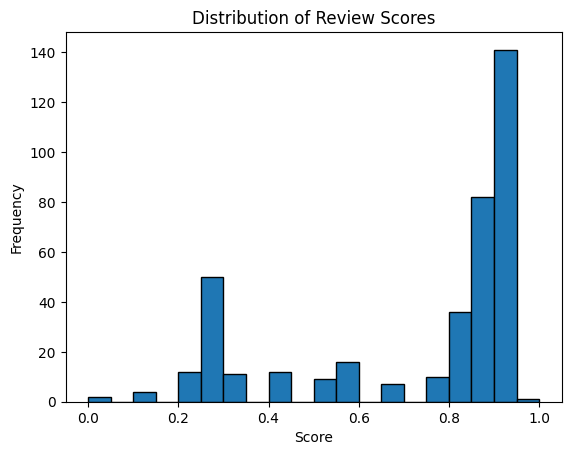

In [6]:
# Plot the distribution of review scores
plt.hist(df['Score'], bins=20, edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Review Scores')
plt.show()

## Classification Model using Sentiment Analysis

### Data Preparation (Classification Specific)

In [7]:
# Filter the DataFrame to only include English reviews
english_df = df[df['Language'] == 'English']
english_df = english_df.reset_index(drop=True)

In [8]:
# Create +ve and -ve labels  
def classify_score(score):  
    if score <= 0.5:  
        return 'Negative'  
    else:  
        return 'Positive'  

english_df['Sentiment'] = english_df['Score'].apply(classify_score)  

# Check distribution  
print(english_df['Sentiment'].value_counts())  

Sentiment
Positive    205
Negative     62
Name: count, dtype: int64


In [9]:
english_df

,Review,Score,Language,Sentiment
0,This movie is amazing! The action is breathtak...,0.92,English,Positive
1,I'm disappointed with the actors' performance....,0.30,English,Negative
2,The storyline is touching and full of emotion....,0.88,English,Positive
3,This movie delivers an outstanding experience....,0.95,English,Positive
4,"Too many action scenes, sometimes unnecessary....",0.60,English,Positive
...,...,...,...,...
262,"Compelling story, outstanding performances",0.88,English,Positive
263,"Intricate plot, unexpected twists",0.90,English,Positive
264,"Underwhelming moments, weak characterizations",0.40,English,Negative
265,"Breathtaking visuals, engaging narrative",0.92,English,Positive


In [10]:
# Compute class weights
class_weights = compute_class_weight(
    "balanced", classes=["Negative", "Positive"], y=english_df["Sentiment"]
)
class_weight_dict = dict(zip([0, 1], class_weights))  # Map to label indices

# Display class weights
print("Class weights:", class_weight_dict)

Class weights: {0: 2.153225806451613, 1: 0.651219512195122}


In [11]:
# Vocab size
all_words = " ".join(english_df["Review"]).split()  # Split all reviews into words
word_counts = Counter(all_words)  # Count word frequencies
vocab = sorted(word_counts.keys())  # Sorted list of unique words

# Assign indices to words (0: padding, 1: unknown/OOV)
word_to_idx = {word: idx + 2 for idx, word in enumerate(vocab)}
word_to_idx["<PAD>"] = 0  # Padding token
word_to_idx["<UNK>"] = 1  # Unknown words

# Print vocabulary size and number of words
print(f"Vocabulary size: {len(vocab)}")
print(f"Number of words: {len(all_words)}")

print(all_words)

Vocabulary size: 1000
Number of words: 4093
['This', 'movie', 'is', 'amazing!', 'The', 'action', 'is', 'breathtaking,', 'and', 'the', 'plot', 'is', 'intriguing.', "I'm", 'disappointed', 'with', 'the', "actors'", 'performance.', 'Not', 'satisfying.', 'The', 'storyline', 'is', 'touching', 'and', 'full', 'of', 'emotion.', 'I', 'love', 'it!', 'This', 'movie', 'delivers', 'an', 'outstanding', 'experience.', 'Truly', 'captivating!', 'Too', 'many', 'action', 'scenes,', 'sometimes', 'unnecessary.', 'Too', 'dramatic.', "I'm", 'thrilled', 'throughout', 'the', 'movie.', 'Engaging', 'storytelling!', 'Avengers:', 'Endgame', 'is', 'disappointing', 'and', 'too', 'cliché.', 'Not', 'enjoyable.', 'I', 'like', 'how', 'this', 'movie', 'combines', 'elements', 'of', 'science', 'fiction.', 'Interesting!', 'This', 'film', 'is', 'truly', 'impressive', 'with', 'deep', 'emotional', 'tones.', 'A', 'cinematic', 'experience', 'that', 'is', 'unforgettable.', "I'm", 'impressed!', 'I', 'feel', 'this', 'movie', "didn't

In [12]:
# Calculate lengths of all reviews (in words)
review_lengths = english_df["Review"].apply(lambda x: len(x.split()))

# Set max_len to cover 90% of reviews (or use median)
max_len = int(np.percentile(review_lengths, 90))  # Adjust percentile as needed
print(f"Optimal max_len: {max_len}")

Optimal max_len: 44


In [13]:
# Split data into train and test sets
X = english_df["Review"].values
y_labels = english_df["Sentiment"].values

X_train, X_test, y_train, y_test = train_test_split(
  X, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

### Train the model

In [14]:
# Tokenize and pad the text data
tokenizer = Tokenizer(num_words=len(vocab) + 2, oov_token="<UNK>")
tokenizer.word_index = word_to_idx  # Use the same word_to_idx mapping

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

In [15]:
# Convert string labels to one-hot encoding
# Map labels to integers: Negative=0, Positive=1
label_map = {"Negative": 0, "Positive": 1}
y_train_int = np.array([label_map[label] for label in y_train])
y_test_int = np.array([label_map[label] for label in y_test])

# One-hot encode
y_train_bin = to_categorical(y_train_int, num_classes=2)
y_test_bin = to_categorical(y_test_int, num_classes=2)

In [16]:
# Add EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Add ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(
    'classification_model.h5', monitor='val_loss', save_best_only=True, mode='min'
)

# Add Learning Rate Scheduling
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=0.0001)

# Model architecture
base_model = Sequential(
    [
        Embedding(input_dim=len(vocab) + 2, output_dim=32, input_length=max_len),
        Dropout(0.3),
        Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))),
        Dropout(0.5),
        Dense(2, activation="sigmoid"),
    ]
)

base_model.compile(
    optimizer=Adam(learning_rate=0.0005),  # or even 0.0001
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Train with class weights and early stopping
history = base_model.fit(
    X_train_pad,
    y_train_bin,
    validation_data=(X_test_pad, y_test_bin),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr, model_checkpoint]
)

Epoch 1/50
7/7 [==============================] - 4s 97ms/step - loss: 1.7091 - accuracy: 0.5540 - val_loss: 1.6732 - val_accuracy: 0.6852 - lr: 5.0000e-04
Epoch 2/50
7/7 [==============================] - 0s 15ms/step - loss: 1.6538 - accuracy: 0.5915 - val_loss: 1.6227 - val_accuracy: 0.7037 - lr: 5.0000e-04
Epoch 3/50
7/7 [==============================] - 0s 15ms/step - loss: 1.6031 - accuracy: 0.5822 - val_loss: 1.5734 - val_accuracy: 0.6296 - lr: 5.0000e-04
Epoch 4/50
7/7 [==============================] - 0s 15ms/step - loss: 1.5510 - accuracy: 0.6291 - val_loss: 1.5263 - val_accuracy: 0.5741 - lr: 5.0000e-04
Epoch 5/50
7/7 [==============================] - 0s 15ms/step - loss: 1.5067 - accuracy: 0.5775 - val_loss: 1.4795 - val_accuracy: 0.6111 - lr: 5.0000e-04
Epoch 6/50
7/7 [==============================] - 0s 16ms/step - loss: 1.4592 - accuracy: 0.5634 - val_loss: 1.4379 - val_accuracy: 0.5556 - lr: 5.0000e-04
Epoch 7/50
7/7 [==============================] - 0s 15ms/step -

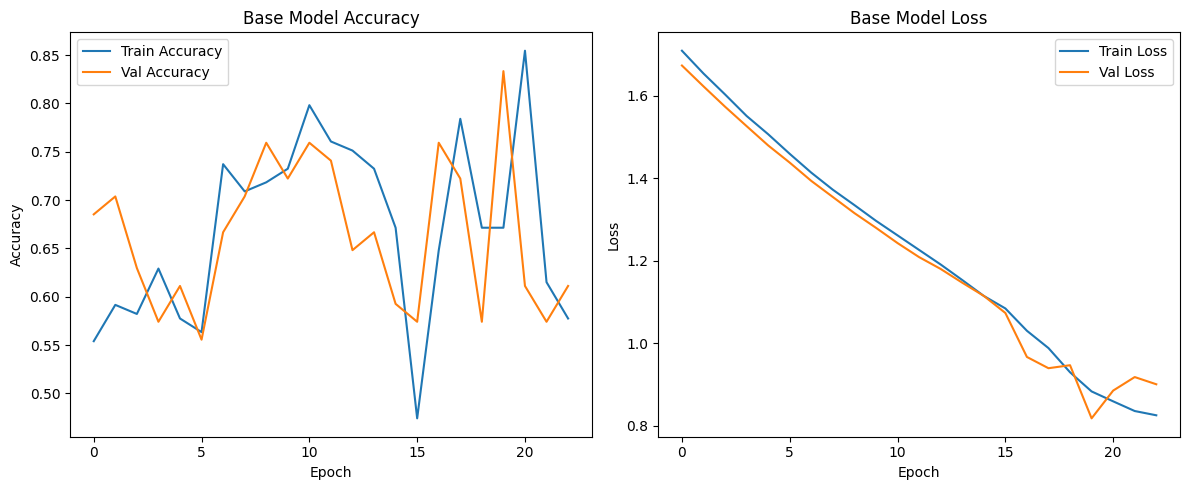

In [17]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Base Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Base Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Predict class probabilities and get predicted labels
y_pred_prob = base_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_bin, axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

2/2 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

    Negative       0.70      0.54      0.61        13
    Positive       0.86      0.93      0.89        41

    accuracy                           0.83        54
   macro avg       0.78      0.73      0.75        54
weighted avg       0.82      0.83      0.83        54



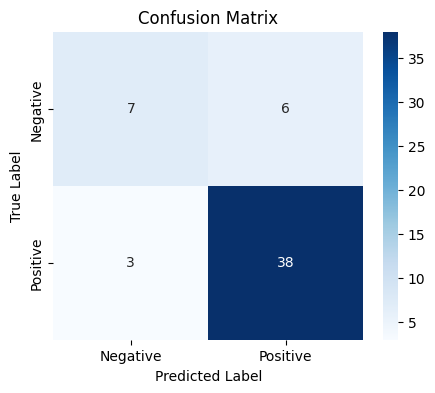

In [19]:
# Plot confusion matrix for classification results
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Regression Model

### Data Preparation (Regression Specific)

In [20]:
# Keep only rows where Language is 'English' or 'Malay'
df = df[df['Language'].isin(['English', 'Malay'])].reset_index(drop=True)

In [21]:
from googletrans import Translator

# Filter Malay reviews
malay_reviews = df[df['Language'] == 'Malay']['Review'].tolist()

# Translate Malay reviews to English
translator = Translator()
translated_reviews = [translator.translate(text, src='ms', dest='en').text for text in malay_reviews]

# Add translations to the dataframe
df.loc[df['Language'] == 'Malay', 'Translated_Review'] = translated_reviews

# Display the updated dataframe
df

,Review,Score,Language,Translated_Review
0,"Sayang sekali, pelakon tidak memberikan persem...",0.20,Malay,"Unfortunately, the actor didn't give the best ..."
1,Jalan cerita yang kompleks dan penuh emosi. Su...,0.80,Malay,Complex and emotional storyline. So entertaining!
2,Pembuat filem berjaya memberikan pengalaman ya...,0.95,Malay,The filmmaker succeeded in providing an unforg...
3,Adegan aksi yang terlalu banyak dan mengejutka...,0.60,Malay,Excessive and shocking action scenes. Sometime...
4,Saya teruja sepanjang filem. Penceritaan yang ...,0.85,Malay,I'm excited throughout the movie. Interesting ...
...,...,...,...,...
386,Pening,0.30,Malay,Dizzy
387,Berkesan,0.80,Malay,Effective
388,Mengujakan,0.90,Malay,Exciting
389,Sederhana and teruk,0.40,Malay,Moderate and severe


In [22]:
def prep_data(df, vocab_size, maxlen, test_size=0.2, val_size=0.1):
    X = df["Review"].astype(str).values
    y = df["Score"].values

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    # Tokenize on the training sets only
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    # Convert texts to sequences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Pad the sequences
    X_train_pad = pad_sequences(
        X_train_seq, maxlen=maxlen, padding="post", truncating="post"
    )
    X_test_pad = pad_sequences(
        X_test_seq, maxlen=maxlen, padding="post", truncating="post"
    )

    # Further split training into training and validation
    X_train_pad, X_val_pad, y_train, y_val = train_test_split(
        X_train_pad, y_train, test_size=val_size, random_state=42
    )

    return X_train_pad, X_val_pad, X_test_pad, y_train, y_val, y_test, tokenizer

In [23]:
# Prepare data for model training without augmentation
X_train, X_val, X_test, y_train, y_val, y_test, tokenizer = prep_data(
    df, vocab_size=1000, maxlen=30
)

### Functions to Build and Evaluate Models

In [24]:
# Function to build a GRU model
def build_gru_model(vocab_size, maxlen):
    model = Sequential(
        [
            Embedding(input_dim=vocab_size, output_dim=64, input_length=maxlen),
            GRU(units=64, return_sequences=True),
            GRU(units=32),
            Dropout(0.4),
            Dense(1, activation="linear"),
        ]
    )

    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae"])

    return model

In [25]:
# Function to train the model and plot loss curves
def train_model(model, X_train, y_train, X_val, y_val, model_name, epochs=50, batch_size=32):
    # Show model architecture
    print(f"\nModel Summary for {model_name}:")
    model.summary()

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    # Loss Curve
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{model_name} MSE Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
# Function to evaluate the model, print evaluation metrics and plot predicted vs actual scores
def evaluate_model(model, model_name, X_test, y_test):
    # Predict
    y_pred = model.predict(X_test, verbose=0).flatten()

    # Evaluation Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n--- Evaluation Summary ({model_name}) ---")
    print(f"Mean Absolute Error (MAE):  {mae * 100:.2f}%")
    print(f"Mean Squared Error (MSE):   {mse * 100:.2f}%")
    print(f"R-squared (R² Score):       {r2:.4f}")

    # Scatter plot of predicted vs true values
    plt.figure()
    plt.scatter(y_test, y_pred, alpha=0.6, color="mediumseagreen")
    # Best fit line
    m, b = np.polyfit(y_test, y_pred, 1)
    x_vals = np.linspace(min(y_test), max(y_test), 100)
    plt.plot(x_vals, m * x_vals + b, linestyle="--", color="red", label="Best Fit Line")
    plt.title(f"{model_name} Predicted vs Actual Scores")
    plt.xlabel("Actual Score")
    plt.ylabel("Predicted Score")
    plt.legend()
    plt.grid(True)
    plt.show()

### Model Training (Without Augmentation)

In [27]:
# Define vocab size and max length
# Vocabulary size
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["Review"].astype(str))
print(f"Vocabulary Size (unique words): {len(tokenizer.word_index)}")

# Max length
print("\nReview Length (word count) Stats:")
print(df["Review"].astype(str).apply(lambda x: len(x.split())).describe())

Vocabulary Size (unique words): 918

Review Length (word count) Stats:
count    391.000000
mean      13.109974
std       13.650234
min        1.000000
25%        2.000000
50%       10.000000
75%       12.000000
max       57.000000
Name: Review, dtype: float64



Model Summary for Base GRU Model:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 64)            64000     
                                                                 
 gru (GRU)                   (None, 30, 64)            24960     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 98,401
Trainable params: 98,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
9/9 

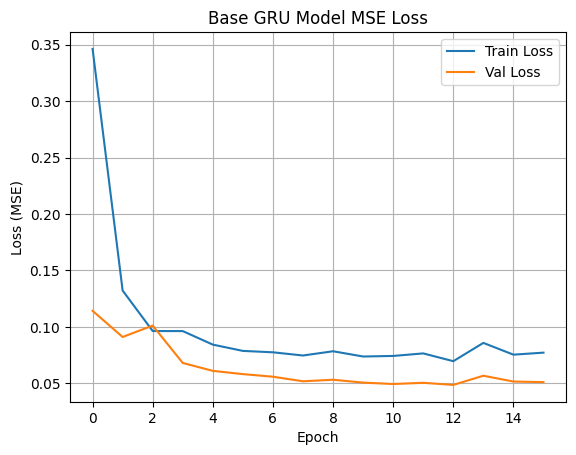

In [28]:
# Build and train the un-augmented GRU model
gru_model = build_gru_model(vocab_size=1000, maxlen=30)

train_model(
    model=gru_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    model_name="Base GRU Model"
)


--- Evaluation Summary (Base GRU Model) ---
Mean Absolute Error (MAE):  23.17%
Mean Squared Error (MSE):   7.31%
R-squared (R² Score):       0.0001


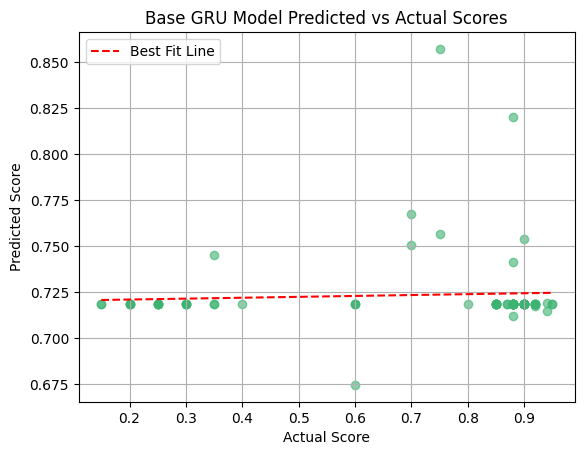

In [29]:
# Evaluate the un-augmented GRU model
evaluate_model(
    model=gru_model,
    model_name="Base GRU Model",
    X_test=X_test,
    y_test=y_test
)

### Augment Training Data

In [30]:
# Define function to augment data with n-grams
def augment_with_ngrams(df, tokenizer, maxlen, min_words=3):
    X_augmented = []
    y_augmented = []

    for text, score in zip(df["Review"], df["SentimentScore"]):
        token_list = tokenizer.texts_to_sequences([text])[0]

        for i in range(min_words, len(token_list) + 1):
            ngram = token_list[:i]
            X_augmented.append(ngram)
            y_augmented.append(score)

    # Pad all sequences
    X_pad = pad_sequences(X_augmented, maxlen=maxlen, padding="post", truncating="post")
    y = np.array(y_augmented)

    return X_pad, y

In [31]:
# Convert sequences to text
df = pd.DataFrame({
    'Review': tokenizer.sequences_to_texts(X_train),
    'SentimentScore': y_train
})

# Augment the training data with n-grams
X_train_aug, y_train_aug = augment_with_ngrams(
    df, tokenizer=tokenizer, maxlen=30
)

# Display the size of the original and augmented training sets
print("Augmentation with n-grams:")
print(f"Original training samples: {len(y_train)}")
print(f"After n-gram expansion:    {len(y_train_aug)}")
print(f"Data increased by:         {len(y_train_aug) - len(y_train)} samples ({(len(y_train_aug) / len(y_train)):.1f}x)"
)

Augmentation with n-grams:
Original training samples: 280
After n-gram expansion:    2523
Data increased by:         2243 samples (9.0x)



Model Summary for Augmented GRU Model:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 64)            64000     
                                                                 
 gru (GRU)                   (None, 30, 64)            24960     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 98,401
Trainable params: 98,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50

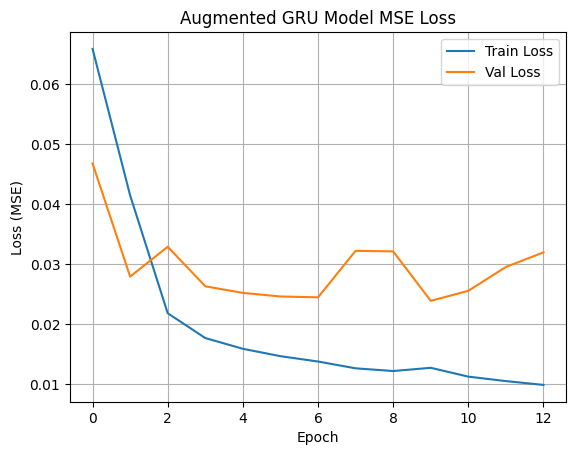

In [32]:
# Train the GRU model with augmented data
train_model(
    model=gru_model,
    X_train=X_train_aug,
    y_train=y_train_aug,
    X_val=X_val,
    y_val=y_val,
    model_name="Augmented GRU Model",
)


--- Evaluation Summary (Augmented GRU Model) ---
Mean Absolute Error (MAE):  10.01%
Mean Squared Error (MSE):   2.39%
R-squared (R² Score):       0.6738


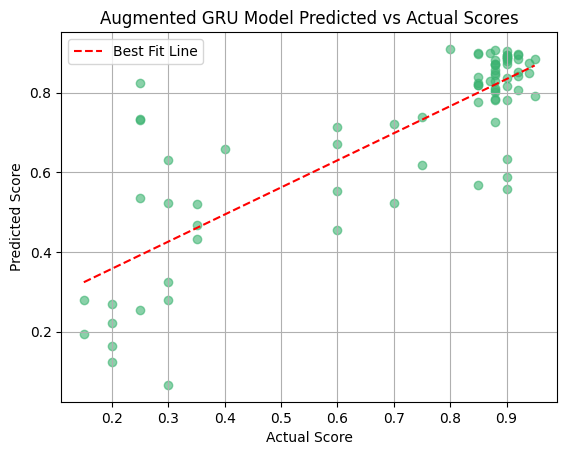

In [33]:
# Evaluate the augmented model
evaluate_model(
  model=gru_model, 
  model_name="Augmented GRU Model", 
  X_test=X_test, 
  y_test=y_test
)

### Model using Random Search for Hyperparameter Tuning

In [34]:
# Define vocab_size and maxlen for this hyperparameter tuning
vocab_size = len(vocab) + 2  # +2 for <PAD> and <UNK>
maxlen = 30

# Use keras-tuner for hyperparameter tuning
def build_model(hp):
    l2_reg = hp.Choice("l2_reg", [1e-5, 1e-4])
    learning_rate = hp.Choice("learning_rate", [1e-5, 5e-5, 1e-4, 5e-4, 1e-3])

    model = Sequential()
    model.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=hp.Choice("embedding_dim", [16, 32, 48]),
            input_length=maxlen,
        )
    )
    model.add(
        GRU(
            units=hp.Int("gru_units", 96, 200, step=32),
            kernel_regularizer=regularizers.l2(l2_reg),
        )
    )
    model.add(Dropout(hp.Float("dropout_rate", 0.2, 0.5, step=0.05)))
    model.add(Dense(1, activation="linear"))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mae"])

    return model

In [35]:
# Create a RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective="val_mae",
    max_trials=200,
    executions_per_trial=2,
    directory="kt_dir",
    project_name="gru_hyperparameter_tuning"
)

# Load existing tuner state if available, or initialize a new tuner
if tuner.oracle.trials:
    print("Tuner reloaded. Showing best trial hyperparameters so far:")
    best_trials = tuner.oracle.get_best_trials(num_trials=1)
    for trial in best_trials:
        print(trial.hyperparameters.values)
else:
    print("Tuner initialized fresh.")

Reloading Tuner from kt_dir\gru_hyperparameter_tuning\tuner0.json
Tuner reloaded. Showing best trial hyperparameters so far:
{'l2_reg': 0.0001, 'learning_rate': 0.001, 'embedding_dim': 16, 'gru_units': 96, 'dropout_rate': 0.35000000000000003}


In [36]:
# Run the hyperparameter search
tuner.search(
    X_train_aug,
    y_train_aug,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True)]
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [37]:
# Evaluate on test data
test_loss, test_mae = best_model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae:.4f}")

3/3 [==============================] - 0s 3ms/step - loss: 0.0184 - mae: 0.0891
Test MAE: 0.0891



Model Summary for Augmented GRU Model (Tuned):
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 16)            16032     
                                                                 
 gru (GRU)                   (None, 96)                32832     
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 48,961
Trainable params: 48,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 [==============================] - 1s 6ms/step - loss: 0.0081 - mae: 0.0639 - val_loss: 0.0192 - val_mae: 0.0921
Epoch 

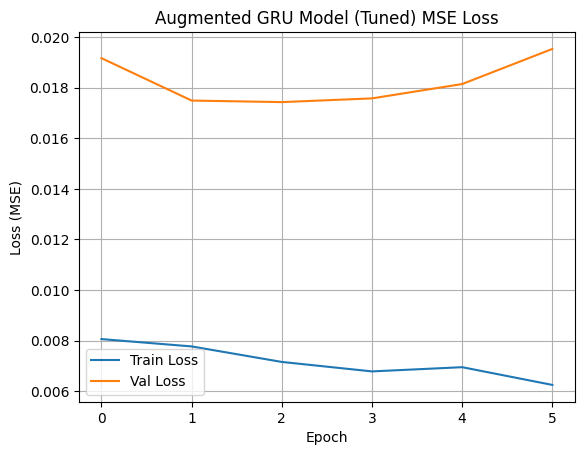

In [38]:
# Train tuned model on augmented data
train_model(
    model=best_model,
    X_train=X_train_aug,
    y_train=y_train_aug,
    X_val=X_val,
    y_val=y_val,
    model_name="Augmented GRU Model (Tuned)",
)


--- Evaluation Summary (Augmented GRU Model (Tuned)) ---
Mean Absolute Error (MAE):  9.81%
Mean Squared Error (MSE):   2.13%
R-squared (R² Score):       0.7084


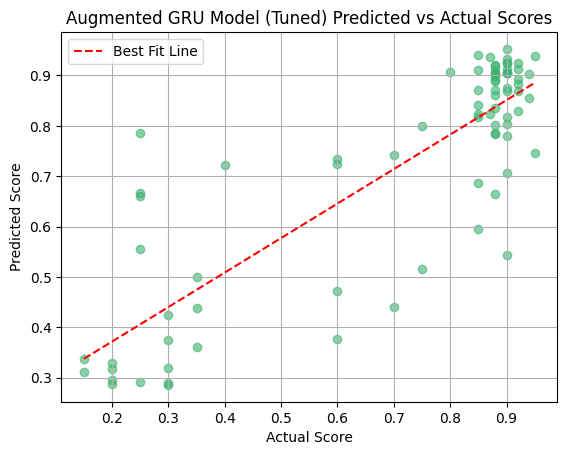

In [39]:
# Evaluate tuned model on augmented test data
evaluate_model(
    model=best_model,
    model_name="Augmented GRU Model (Tuned)", 
    X_test=X_test, 
    y_test=y_test
)


Model Summary for Un-augmented GRU Model (Tuned):
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 16)            16032     
                                                                 
 gru (GRU)                   (None, 96)                32832     
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 48,961
Trainable params: 48,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
9/9 [==============================] - 0s 12ms/step - loss: 0.0191 - mae: 0.0900 - val_loss: 0.0183 - val_mae: 0.0812
Epoc

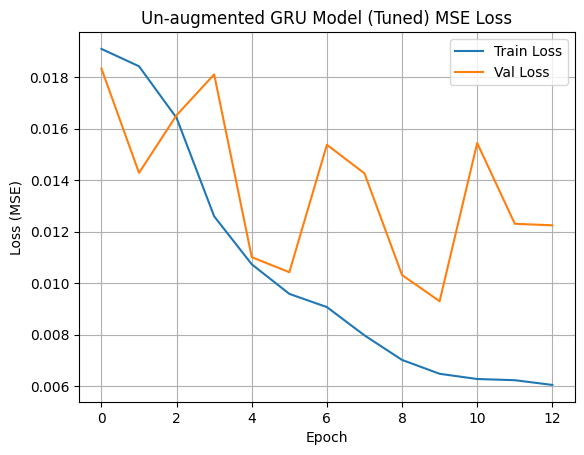

In [40]:
# Train tuned model on un-augmented data
train_model(
    model=best_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    model_name="Un-augmented GRU Model (Tuned)",
)


--- Evaluation Summary (Un-augmented GRU Model (Tuned)) ---
Mean Absolute Error (MAE):  8.15%
Mean Squared Error (MSE):   1.56%
R-squared (R² Score):       0.7874


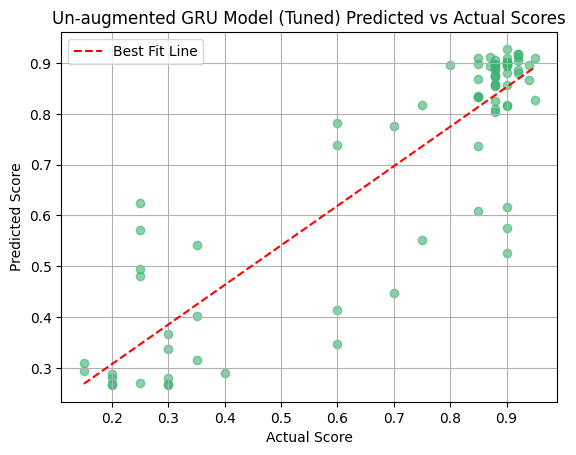

In [41]:
# Evaluate tuned model on un-augmented test data
evaluate_model(
    model=best_model,
    model_name="Un-augmented GRU Model (Tuned)",
    X_test=X_test,
    y_test=y_test,
)

In [42]:
best_model.save('best_GRU_model.h5')